In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from crn_utils import SimulationOptions, run_simulation
import numpy as np

simulation_options = SimulationOptions()
simulation_options.set_java_path("/home/harry/.jdks/openjdk-19.0.1/bin/java")
simulation_options.set_max_time(2000)

In [2]:
simulation_options.net_from_file("./nets/double-b.json")
simulation_options.set_repeats(500)
simulation_options.set_volumes([int(volume) for volume in np.logspace(2.0, 4.0, 10)])
simulation_options.use_temp_file(True)
simulation_options.set_format("csv")

DATA = run_simulation(simulation_options)
places = DATA.columns.difference(["repeatNum", "time", "volume"])
DATA = DATA.sort_values(["volume", "repeatNum", "time"], ascending = [True, True, True])
DATA["isFinal"] = DATA.time.eq(DATA.groupby(['volume','repeatNum']).time.transform('max'))

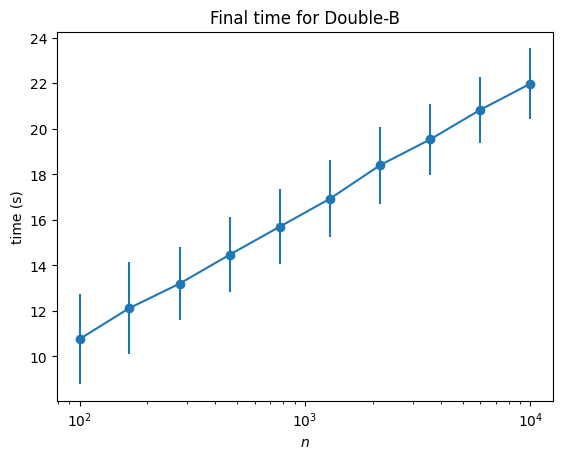

In [3]:
t_end_av = []
t_end_err = []
n_vals = []

for n in DATA["volume"].unique():
    t_end = []
    for repeat in DATA["repeatNum"].unique():
        t_end.append(DATA[DATA["volume"].eq(n) & DATA["repeatNum"].eq(repeat)]["time"].max())
    t_end_av.append(np.mean(t_end))
    t_end_err.append(np.std(t_end))
    n_vals.append(n)

plt.xscale("log")
plt.xlabel("$n$")
plt.ylabel("time (s)")
plt.scatter(n_vals, t_end_av)
plt.errorbar(n_vals, t_end_av, t_end_err)
plt.title("Final time for Double-B")
plt.show()

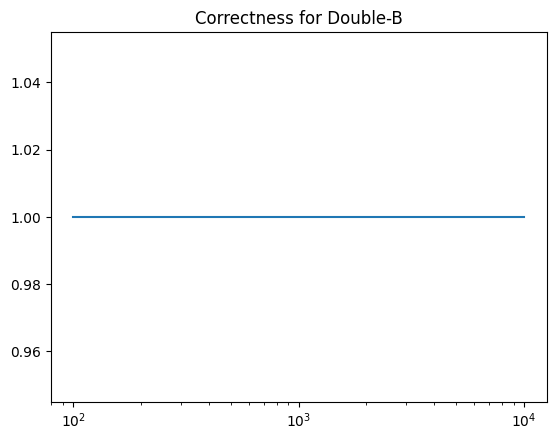

In [8]:
x_vol = []
y_correctness = []
volume_lowest_correctness = ""
lowest = 1.1
for volume in DATA["volume"].unique():
    x_vol.append(volume)
    correct = DATA[DATA["volume"].eq(volume) & DATA["isFinal"] & DATA["X"].eq(0)].size
    incorrect = DATA[DATA["volume"].eq(volume) & DATA["isFinal"] & DATA["X"].ne(0)].size
    ratio = correct/(correct+incorrect)
    y_correctness.append(ratio)
    if ratio < lowest:
        volume_lowest_correctness = volume
        lowest = ratio

plt.plot(x_vol, y_correctness)
plt.xscale('log')
plt.title("Correctness for Double-B")
plt.show()

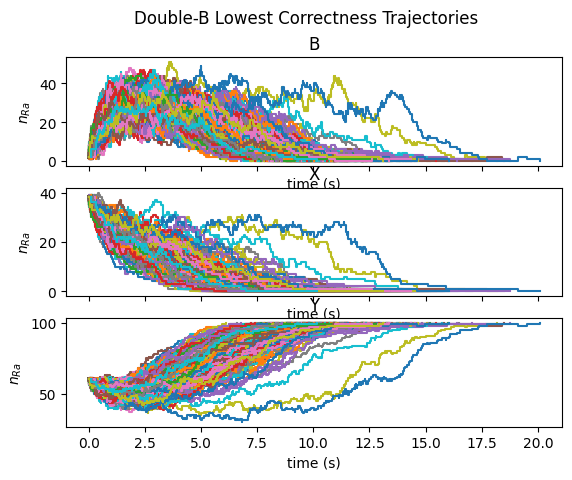

In [9]:
fig, axs = plt.subplots(len(places), sharex=True)
fig.suptitle("Double-B Lowest Correctness Trajectories")

d_low = DATA[DATA["volume"].eq(volume_lowest_correctness)]

row = 0
for place in places:
    for repeat in d_low["repeatNum"].unique():
        axs[row].step(d_low[d_low["repeatNum"] == repeat]["time"], d_low[d_low["repeatNum"] == repeat][place], where='post', label="{}-{}".format(place, repeat))
        axs[row].set_xlabel("time (s)")
        axs[row].set_ylabel("$n_{Ra}$")
        axs[row].set_title(place)
    row += 1